# EDA-3

## 1. Importing Data 

In [ ]:
import pandas as pd
import numpy as np

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

In [ ]:
df=pd.read_csv("../../Datasets/cleaned_senti_reviews.csv")

In [ ]:
df.shape

(130633, 58)

In [ ]:
df.head(2)

,Unnamed: 0,reviewer_id,listing_id,date,reviewer_name,comments,name,description,neighborhood_overview,host_id,...,review_scores_cleanliness,review_scores_checkin,review_scores_communication,review_scores_location,review_scores_value,instant_bookable,calculated_host_listings_count,reviews_per_month,polarity_score,sentiment
0,0,8557223,49091,2013-10-21,Jared,Fran was absolutely gracious and welcoming. Ma...,COZICOMFORT LONG TERM STAY ROOM 2,This is Room No. 2.(available after Jan 15 201...,NaN,266763,...,10.0,10.0,10.0,8.0,8.0,f,2,0.02,0.9615,pos
1,1,1356099,50646,2014-04-18,James,A comfortable room in a smart condo developmen...,Pleasant Room along Bukit Timah,Fully furnished bedroom with a nice view on th...,The serenity & quiet surrounding makes it an i...,227796,...,10.0,10.0,10.0,9.0,9.0,f,1,0.30,0.9484,pos


##  2. Feature Pre-Processing


###  2.1 Feature: host_response_rate

#### What the Feature Looks Like

In [ ]:
df.host_response_rate.dtype

dtype('O')

In [ ]:
df.host_response_rate.isnull().value_counts()

False    125371
True       5262
Name: host_response_rate, dtype: int64

In [ ]:
df.host_response_rate.value_counts().head()

100%    81124
99%      7999
97%      5676
98%      5603
86%      3087
Name: host_response_rate, dtype: int64

#### Drop the Rows with host_response_rate Values Being NAs

In [ ]:
df.dropna(subset=["host_response_rate"],inplace=True)

In [ ]:
df.shape

(125371, 58)

#### Transform Strings into Floats

In [ ]:
df.host_response_rate = df.host_response_rate.apply(lambda x: int(x[:-1])/100)

In [ ]:
df.host_response_rate.dtype

dtype('float64')

### 2.2 Feature: host_response_time 

#### What the Feature Looks Like

In [ ]:
df.host_response_time.isnull().value_counts()

False    125371
Name: host_response_time, dtype: int64

In [ ]:
df.host_response_time.value_counts()

within an hour        96595
within a few hours    22579
within a day           5445
a few days or more      752
Name: host_response_time, dtype: int64

Therefore, we decided to transform the four textual values into integers. The faster the response, the higher its integer value.

   - "within an hour": 4      
   - "within a few hours": 3
   - "within a day": 2 
   - "a few days or more": 1

#### Transform Strings into Integers

In [ ]:
df["host_response_time"].replace({"within an hour": 4,
                                  "within a few hours": 3,
                                  "within a day": 2, 
                                  "a few days or more": 1
                                  }, inplace=True)

In [ ]:
df.host_response_time.value_counts()

4    96595
3    22579
2     5445
1      752
Name: host_response_time, dtype: int64

### 2.4 Feature Cross: host_response_score 

Crossing host_response_time and host_response_rate features. The higher the score, the more responsive a host is. 

In [ ]:
df.host_response_time.value_counts()

4    96594
3    22579
2     5445
1      752
Name: host_response_time, dtype: int64

In [ ]:
df["response_score"]=df.host_response_time+4*df.host_response_rate

In [ ]:
df.response_score.value_counts()

8.00    69070
7.00    10657
7.96     7386
7.92     5180
7.88     4757
        ...  
4.08        1
2.36        1
1.96        1
2.88        1
1.36        1
Name: response_score, Length: 128, dtype: int64

## 3. Explore: Relationship between Hosts' Response Service and Housing Experience

#### Group the Data by listing_id to Obtain the Average Polarity Score of a Listing

In [ ]:
df2=df[["listing_id","response_score","polarity_score","host_response_time","host_response_rate","host_is_superhost"]]
df2

,listing_id,response_score,polarity_score,host_response_time,host_response_rate,host_is_superhost
0,49091,7.00,0.9615,3,1.00,f
19,56334,7.00,0.8316,3,1.00,f
20,56334,7.00,0.9825,3,1.00,f
21,56334,7.00,0.8851,3,1.00,f
22,56334,7.00,0.9077,3,1.00,f
...,...,...,...,...,...,...
130628,46568588,6.72,-0.8530,3,0.93,f
130629,46569171,6.72,0.9600,3,0.93,f
130630,46569258,6.72,0.5719,3,0.93,f
130631,46846222,6.72,0.7418,3,0.93,f


In [ ]:
df2.host_is_superhost.value_counts()

f    86959
t    38411
Name: host_is_superhost, dtype: int64

In [ ]:
df3= pd.pivot_table(df2,
                    index=["listing_id","host_is_superhost"],
                    values=["response_score","polarity_score","host_response_time","host_response_rate","host_is_superhost"]
                   )

In [ ]:
df3.shape

(8328, 4)

#### Using Scatter Plot to Explore the Relationship between host_response_score and polarity_score


In [ ]:
np.corrcoef(df3.polarity_score,df3.response_score)

array([[1.        , 0.04216048],
       [0.04216048, 1.        ]])

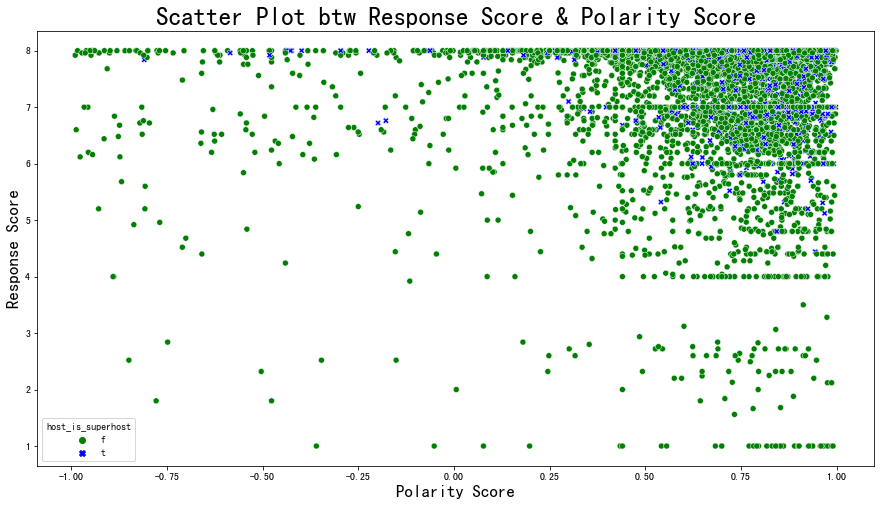

In [ ]:
plt.figure(figsize=(15,8))

sns.scatterplot(data=df3,
                x="polarity_score",
                y="response_score",
                hue="host_is_superhost",
                style="host_is_superhost",
                palette=['green','blue'],
                #alpha=0.3
               )

plt.title("Scatter Plot btw Response Score & Polarity Score",fontsize=25)

plt.xlabel('Polarity Score', fontsize=17)
plt.ylabel('Response Score', fontsize=17)

plt.savefig('../Pictures/EDA3.1.png')

plt.show()

#### Enlarge the Top Right Corner

In [ ]:
df4=df3.copy()

In [ ]:
df4.polarity_score=df4.polarity_score[df4.polarity_score>0.25]
df4.response_score=df4.response_score[df4.response_score>6]

In [ ]:
df4

,,host_response_rate,host_response_time,polarity_score,response_score
listing_id,host_is_superhost,,,,
49091,f,1.00,3.000000,0.961500,7.000000
56334,f,1.00,3.000000,0.948600,7.000000
71609,f,1.00,3.933333,0.756153,7.933333
71896,f,1.00,4.000000,0.859250,8.000000
71903,f,1.00,3.923077,0.636513,7.923077
...,...,...,...,...,...
46846222,f,0.95,3.333333,0.802233,7.133333
47014450,f,1.00,4.000000,0.726400,8.000000
47039804,f,0.86,4.000000,0.585900,7.440000


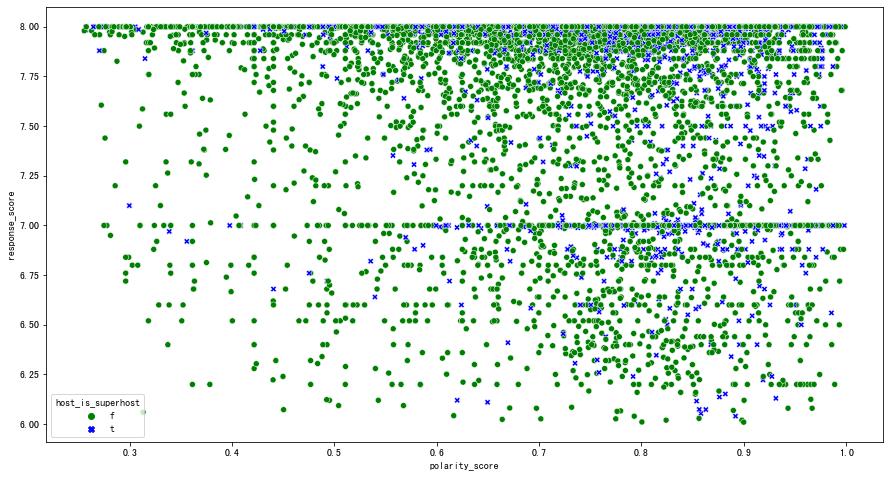

In [ ]:
plt.figure(figsize=(15,8))


sns.scatterplot(data=df4,
                x="polarity_score",
                y="response_score",
                hue="host_is_superhost",
                style="host_is_superhost",
                palette=['green','blue'],
                #alpha=0.3
               )


plt.savefig('../Pictures/EDA3.2.png')

plt.show()